In [1]:
# Import necessary libraries
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from timm import create_model
from einops import rearrange
import torch.nn as nn
import torch.nn.functional as F
import tifffile as tiff
from torchvision import transforms
import cv2
from tqdm.notebook import tqdm
import torchvision
# Set seed for reproducibility
pl.seed_everything(42)

Seed set to 42


42

In [2]:
from multissl.models import FastSiam

In [3]:
def clean_state_dict(
    state_dict,
    prefix_to_strip="backbone.",
    skip_if_contains=None
):
    """
    Create a new state_dict with:
      1) The specified prefix stripped from the start of each key.
      2) Certain keys *entirely removed* if they match a skip pattern.

    :param state_dict: (dict) The original state_dict.
    :param prefix_to_strip: (str) If a key starts with this prefix, remove that prefix.
    :param skip_if_contains: (list of str or None)
            If not None, any key containing ANY of these substrings is skipped entirely.
    :return: (dict) A new state_dict with modified/filtered keys.
    """
    if skip_if_contains is None:
        skip_if_contains = []

    new_state_dict = {}
    for key, value in state_dict.items():
        # 1) Check if we should skip this key entirely
        #    (if the key contains any of the "skip" substrings)
        if any(skip_str in key for skip_str in skip_if_contains):
            continue

        # 2) Strip prefix if present
        if key.startswith(prefix_to_strip):
            new_key = key[len(prefix_to_strip):]
        else:
            new_key = key

        new_state_dict[new_key] = value

    return new_state_dict


In [4]:
from multissl.data import tifffile_loader
from multissl.data.transforms import UIntToFloat, Transpose, ToTensor
from torchvision import transforms
import cv2

def load_tiff_tensor(path, image_size=None):
    """
    Load a TIFF file, optionally resize to (image_size, image_size), 
    then run through the transform pipeline to get a PyTorch tensor.
    """
    # 1) Read as NumPy array
    image_array = tifffile_loader(path)  # shape could be H×W or H×W×C
    
    # 2) Optionally resize if image_size is given
    if image_size is not None:
        # If image_array is (H, W) or (H, W, C), handle both
        if image_array.ndim == 2:
            # Grayscale => H×W
            image_array = cv2.resize(image_array, (image_size, image_size),
                                     interpolation=cv2.INTER_AREA)
        elif image_array.ndim == 3:
            # Color => H×W×C
            # Note cv2.resize wants (W, H) as the second argument
            h, w, c = image_array.shape
            image_array = cv2.resize(image_array, (image_size, image_size),
                                     interpolation=cv2.INTER_AREA)
        else:
            raise ValueError(f"Unsupported shape {image_array.shape}.")
    base = [UIntToFloat(), Transpose(), ToTensor()]
    # 3) Apply transform pipeline (normalization, transpose, tensor)
    pipeline = transforms.Compose(base) 
      # shape will end up as (C, H, W)
    
    return pipeline(image_array).unsqueeze(0), image_array
def modify_resnet_for_4_channels(resnet, in_channels):
    """Modifies the first ResNet conv layer to accept 4-channel input."""
    old_conv = resnet.conv1
    new_conv = nn.Conv2d(
        in_channels,  # Change from 3 to 4 channels
        old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=False
    )
        # Reinitialize new conv weights while keeping pretrained filter values
    with torch.no_grad():
        new_conv.weight[:, :3] = old_conv.weight  # Copy original RGB filters
        new_conv.weight[:, 3] = old_conv.weight[:, 0]  # Initialize NIR with Red channel weights
    
    resnet.conv1 = new_conv  # Replace conv1 with modified conv
    return resnet

class Flatten(nn.Module):
    """Simple module to flatten from [B, C, H, W] -> [B, C*H*W] or [B, C, 1, 1] -> [B, C]"""
    def forward(self, x):
        return x.flatten(start_dim=1)


In [62]:
class ResNetExtractor(nn.Module):
    def __init__(self, resnet):
        super().__init__()
        # Store the components we need
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        # Store the blocks
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
    
    def forward(self, x):
        features = {}
        
        # Initial processing
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        features['initial'] = x
        
        x = self.maxpool(x)
        
        # Process through blocks
        x = self.layer1(x)
        features['layer1'] = x
        
        x = self.layer2(x)
        features['layer2'] = x
        
        x = self.layer3(x)
        features['layer3'] = x
        
        x = self.layer4(x)
        features['layer4'] = x
        
        return features
        
class SegmentationHead(nn.Module):
    """
    Improved Segmentation head with UNet-style decoder path and skip connections
    that explicitly handles different feature map sizes
    """
    def __init__(self, layer1_channels, layer2_channels, layer3_channels, layer4_channels, 
                 num_classes=2, img_size=224):
        super().__init__()
        
        self.img_size = img_size
        self.act = nn.ReLU(inplace=True)
        
        # Reduce channel dimensions of encoder features, but keep more channels
        self.reduce1 = nn.Conv2d(layer1_channels, 64, kernel_size=1)  # 1/4 resolution
        self.reduce2 = nn.Conv2d(layer2_channels, 128, kernel_size=1)  # 1/8 resolution
        self.reduce3 = nn.Conv2d(layer3_channels, 256, kernel_size=1)  # 1/16 resolution
        self.reduce4 = nn.Conv2d(layer4_channels, 512, kernel_size=1)  # 1/32 resolution
        
        # Decoder path (upsampling + conv)
        # Layer 4 -> Layer 3
        self.up4_3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.decode3 = nn.Conv2d(256 + 256, 256, kernel_size=3, padding=1)
        
        # Layer 3 -> Layer 2
        self.up3_2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.decode2 = nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1)
        
        # Layer 2 -> Layer 1
        self.up2_1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.decode1 = nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1)
        
        # Final upsampling to original resolution
        self.final_up = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )
        
    def forward(self, features):
        """Process features through decoder path with skip connections"""
        # Extract and reduce features from backbone
        f1 = self.act(self.reduce1(features['layer1']))  # 1/4 resolution
        f2 = self.act(self.reduce2(features['layer2']))  # 1/8 resolution
        f3 = self.act(self.reduce3(features['layer3']))  # 1/16 resolution
        f4 = self.act(self.reduce4(features['layer4']))  # 1/32 resolution
        
        # Print shapes for debugging
        # print(f"f1: {f1.shape}, f2: {f2.shape}, f3: {f3.shape}, f4: {f4.shape}")
        
        # Decoder path with skip connections (UNet style)
        # Layer 4 -> Layer 3 with explicit size matching
        x = self.up4_3(f4)
        x = F.interpolate(x, size=f3.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, f3], dim=1)
        x = self.act(self.decode3(x))
        
        # Layer 3 -> Layer 2 with explicit size matching
        x = self.up3_2(x)
        x = F.interpolate(x, size=f2.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, f2], dim=1)
        x = self.act(self.decode2(x))
        
        # Layer 2 -> Layer 1 with explicit size matching
        x = self.up2_1(x)
        x = F.interpolate(x, size=f1.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, f1], dim=1)
        x = self.act(self.decode1(x))
        
        # Final upsampling to original resolution
        x = self.final_up(x)
        x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        x = self.classifier(x)
        
        return x
        
    def _debug_print_shapes(self, features):
        """Helper method to print feature shapes for debugging"""
        print(f"layer1: {features['layer1'].shape}")
        print(f"layer2: {features['layer2'].shape}")
        print(f"layer3: {features['layer3'].shape}")
        print(f"layer4: {features['layer4'].shape}")
        
        f1 = self.reduce1(features['layer1'])
        f2 = self.reduce2(features['layer2'])
        f3 = self.reduce3(features['layer3'])
        f4 = self.reduce4(features['layer4'])
        
        print(f"f1: {f1.shape}")
        print(f"f2: {f2.shape}")
        print(f"f3: {f3.shape}")
        print(f"f4: {f4.shape}")
        
        
class ResNetSegmentationModel(pl.LightningModule):
    """
    Complete model combining pretrained ResNet backbone with segmentation head
    """
    def __init__(
        self, 
        sequential_backbone,
        num_classes=2, 
        img_size=224,
        lr=1e-4, 
        weight_decay=1e-5
    ):
        super().__init__()
        
        # Initialize feature extractor
        self.feature_extractor = ResNetExtractor(backbone)
        
        # Freeze backbone weights
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        
        # Detect feature dimensions immediately by running a forward pass
        with torch.no_grad():
            dummy_input = torch.zeros(1, 4, img_size, img_size)  # Adjust channels if needed
            features = self.feature_extractor(dummy_input)
            
            # Extract channel dimensions from features
            layer1_channels = features['layer1'].size(1)
            layer2_channels = features['layer2'].size(1)
            layer3_channels = features['layer3'].size(1)
            layer4_channels = features['layer4'].size(1)
            
            print(f"Detected feature dimensions: layer1={layer1_channels}, layer2={layer2_channels}, "
                  f"layer3={layer3_channels}, layer4={layer4_channels}")
        
        # Initialize segmentation head with correct dimensions
        self.seg_head = SegmentationHead(
            layer1_channels=layer1_channels,
            layer2_channels=layer2_channels,
            layer3_channels=layer3_channels,
            layer4_channels=layer4_channels,
            num_classes=num_classes,
            img_size=img_size
        )
        
        # Training parameters
        self.lr = lr
        self.weight_decay = weight_decay
        
    def forward(self, x):
        """Forward pass through backbone and segmentation head"""
        features = self.feature_extractor(x)
        segmentation_map = self.seg_head(features)
        return segmentation_map

    def dice_loss(self, outputs, targets, smooth=1.0):
        num_classes = outputs.size(1)
        
        # One-hot encode targets
        targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()
        
        # Apply softmax to get probabilities
        probs = F.softmax(outputs, dim=1)
        
        # Calculate Dice loss
        intersection = (probs * targets_one_hot).sum(dim=(0, 2, 3))
        union = probs.sum(dim=(0, 2, 3)) + targets_one_hot.sum(dim=(0, 2, 3))
        
        dice_score = (2.0 * intersection + smooth) / (union + smooth)
        
        # Focus more on vine class (class 1)
        class_weights = torch.tensor([0.5, 1.5], device=outputs.device)
        weighted_dice = dice_score * class_weights
        
        return 1.0 - weighted_dice.mean()
        
    def combined_loss(self, outputs, targets, ce_weight=0.5, dice_weight=0.5):
        # Define class weights for CE loss
        class_weights = torch.tensor([1.0, 3.0], device=outputs.device)
        
        # Calculate CE loss
        ce_loss = F.cross_entropy(outputs, targets, weight=class_weights)
        
        # Calculate Dice loss
        dice = self.dice_loss(outputs, targets)
        
        # Combine losses
        return ce_weight * ce_loss + dice_weight * dice
    
    def training_step(self, batch, batch_idx):
        """Training step with mixed dice, weighted cross-entropy loss"""
        images, masks = batch
        logits = self(images)

        # Dice loss for segmentation
        loss = self.combined_loss(logits, masks)
        
        # Log metrics
        self.log("train_loss", loss, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        """Validation step with metrics calculation"""
        images, masks = batch
        logits = self(images)
        
        # Cross entropy loss
        loss = F.cross_entropy(logits, masks)
        
        # Calculate pixel accuracy
        preds = torch.argmax(logits, dim=1)
        accuracy = (preds == masks).float().mean()
        
        # Log metrics
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", accuracy, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        """Configure optimizer with learning rate scheduler"""
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.5, 
            patience=5,
            verbose=True
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch"
            }
        }
    
    def unfreeze_backbone(self, fine_tune_layers=None):
        """
        Unfreeze backbone layers for fine-tuning
        Args:
            fine_tune_layers: List of layer names to unfreeze, or None to unfreeze all
        """
        if fine_tune_layers is None:
            # Unfreeze all backbone parameters
            for param in self.feature_extractor.parameters():
                param.requires_grad = True
        else:
            # Unfreeze only specific layers
            for layer_name in fine_tune_layers:
                if hasattr(self.feature_extractor.backbone, layer_name):
                    for param in getattr(self.feature_extractor.backbone, layer_name).parameters():
                        param.requires_grad = True

    def test_step(self, batch, batch_idx):
        """
        Run test step on a single batch
        """
        images, masks = batch
        
        # Forward pass
        logits = self(images)
        
        # Cross entropy loss
        loss = F.cross_entropy(logits, masks)
        
        # Get predictions
        preds = torch.argmax(logits, dim=1)
        
        # Calculate accuracy
        accuracy = (preds == masks).float().mean()
        
        # Initialize metrics per class
        num_classes = logits.shape[1]
        metrics_per_class = []
        confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.long, device=self.device)
        
        # Calculate metrics for each class and build confusion matrix
        for i in range(num_classes):
            for j in range(num_classes):
                confusion_matrix[i, j] = ((preds == j) & (masks == i)).sum()
        
        for c in range(num_classes):
            # True positives, false positives, false negatives
            true_pos = ((preds == c) & (masks == c)).sum().float()
            false_pos = ((preds == c) & (masks != c)).sum().float()
            false_neg = ((preds != c) & (masks == c)).sum().float()
            
            # Calculate metrics, avoiding division by zero
            precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else torch.tensor(0.0, device=self.device)
            recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else torch.tensor(0.0, device=self.device)
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else torch.tensor(0.0, device=self.device)
            
            # Calculate IoU (Intersection over Union) for this class
            iou = true_pos / (true_pos + false_pos + false_neg) if (true_pos + false_pos + false_neg) > 0 else torch.tensor(0.0, device=self.device)
            
            metrics_per_class.append({
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'iou': iou
            })
        
        # Calculate overall metrics (micro average across all classes)
        total_true_pos = sum(confusion_matrix[i, i] for i in range(num_classes)).float()
        total_elements = confusion_matrix.sum().float()
        total_precision = total_true_pos / total_elements if total_elements > 0 else torch.tensor(0.0, device=self.device)
        total_f1 = 2 * total_precision * total_precision / (total_precision + total_precision) if total_precision > 0 else torch.tensor(0.0, device=self.device)
        
        # Return metrics to be accumulated
        return {
            'test_loss': loss,
            'test_accuracy': accuracy,
            'confusion_matrix': confusion_matrix,
            'metrics_per_class': metrics_per_class,
            'total_f1': total_f1
        }
    
    def test_epoch_end(self, outputs):
        """
        Aggregate metrics from all test batches
        """
        num_classes = len(outputs[0]['metrics_per_class'])
        class_names = ["Background", "Vines"]  # Adjust based on your classes
        
        # Aggregate test loss and accuracy
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_accuracy = torch.stack([x['test_accuracy'] for x in outputs]).mean()
        
        # Aggregate confusion matrix
        total_confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.long, device=self.device)
        for output in outputs:
            total_confusion_matrix += output['confusion_matrix']
        
        # Aggregate metrics per class
        avg_metrics_per_class = []
        for c in range(num_classes):
            avg_precision = torch.stack([x['metrics_per_class'][c]['precision'] for x in outputs]).mean()
            avg_recall = torch.stack([x['metrics_per_class'][c]['recall'] for x in outputs]).mean()
            avg_f1 = torch.stack([x['metrics_per_class'][c]['f1'] for x in outputs]).mean()
            avg_iou = torch.stack([x['metrics_per_class'][c]['iou'] for x in outputs]).mean()
            
            avg_metrics_per_class.append({
                'precision': avg_precision,
                'recall': avg_recall,
                'f1': avg_f1,
                'iou': avg_iou
            })
        
        # Calculate mean IoU across all classes
        mean_iou = torch.stack([metrics['iou'] for metrics in avg_metrics_per_class]).mean()
        
        # Calculate total F1 score (micro-average)
        total_f1 = torch.stack([x['total_f1'] for x in outputs]).mean()
        
        # Log metrics
        self.log('test_loss', avg_loss)
        self.log('test_accuracy', avg_accuracy)
        self.log('test_mean_iou', mean_iou)
        self.log('test_total_f1', total_f1)
        
        for c in range(num_classes):
            class_name = class_names[c] if c < len(class_names) else f"class_{c}"
            self.log(f'test_{class_name}_precision', avg_metrics_per_class[c]['precision'])
            self.log(f'test_{class_name}_recall', avg_metrics_per_class[c]['recall'])
            self.log(f'test_{class_name}_f1', avg_metrics_per_class[c]['f1'])
            self.log(f'test_{class_name}_iou', avg_metrics_per_class[c]['iou'])
        
        # Print results
        print("\n===== Test Set Evaluation =====")
        print(f"Loss: {avg_loss:.4f}")
        print(f"Accuracy: {avg_accuracy:.4f}")
        print(f"Total F1 Score (micro-avg): {total_f1:.4f}")
        print(f"Mean IoU: {mean_iou:.4f}")
        
        print("\nPer-class metrics:")
        for i in range(num_classes):
            class_name = class_names[i] if i < len(class_names) else f"Class {i}"
            print(f"{class_name}:")
            print(f"  Precision: {avg_metrics_per_class[i]['precision']:.4f}")
            print(f"  Recall: {avg_metrics_per_class[i]['recall']:.4f}")
            print(f"  F1 Score: {avg_metrics_per_class[i]['f1']:.4f}")
            print(f"  IoU: {avg_metrics_per_class[i]['iou']:.4f}")
        
        print("\nConfusion Matrix:")
        print(total_confusion_matrix)
        
        # Return the metrics dictionary
        return {
            "test_loss": avg_loss,
            "test_accuracy": avg_accuracy,
            "test_total_f1": total_f1,
            "test_mean_iou": mean_iou,
            "test_confusion_matrix": total_confusion_matrix,
            "test_metrics_per_class": avg_metrics_per_class
        }
    
    def test(self, test_loader=None):
        """
        Comprehensive evaluation of segmentation model on test set
        This method can be called manually and provides a more organized output
        compared to trainer.test()
        
        Args:
            test_loader: Optional DataLoader for test data
        
        Returns:
            Dictionary with evaluation metrics
        """
        if test_loader is None:
            raise ValueError("test_loader must be provided")
        
        self.eval()
        torch.set_grad_enabled(False)
        
        # Run test batches through test_step
        outputs = []
        for batch_idx, batch in enumerate(test_loader):
            batch = [x.to(self.device) for x in batch]
            output = self.test_step(batch, batch_idx)
            outputs.append(output)
        
        # Process results
        results = self.test_epoch_end(outputs)
        torch.set_grad_enabled(True)
        
        return results


In [64]:
def create_false_color_image(tensor):

    """Convert a PyTorch tensor image to a NumPy array for visualization."""
    tensor = tensor.cpu().detach()  # Ensure it's detached from the computation graph
    tensor = tensor.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
    image = tensor.numpy()
      # False Color Composite (NIR, RED, GREEN)
    false_color = np.stack([image[:, :, 3], image[:, :, 1], image[:, :, 0]], axis=-1)  # (H, W, 3)
    return false_color

def visualize_batch(batch, num_samples=4, class_names=None, num_classes=None):
    """Visualize a batch of images and their corresponding masks."""
    images, masks = batch
    
    if num_classes is None:
        num_classes = masks.max().item() + 1
    
    # Create a figure with two rows (images and masks)
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i in range(num_samples):
        # Get current image and mask
        image = images[i]
        mask = masks[i]
        
        # Create false color image for visualization
        false_color = create_false_color_image(image)
        
        # Plot image
        axes[0, i].imshow(false_color)
        axes[0, i].set_title(f"Image {i}")
        axes[0, i].axis('off')
        
        # Plot mask with colormap
        if num_classes <= 10:
            cmap = plt.get_cmap('tab10', num_classes)
        else:
            cmap = plt.get_cmap('viridis', num_classes)
            
        im = axes[1, i].imshow(mask.cpu().numpy(), cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[1, i].set_title(f"Mask {i}")
        axes[1, i].axis('off')
    
    # Add a colorbar if class names are provided
    if class_names:
        cbar = fig.colorbar(im, ax=axes[1,-1], shrink=0.7)
        cbar.set_ticks(np.arange(num_classes) + 0.5)
        cbar.set_ticklabels(class_names)
    
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataloader, device, num_samples=4, class_names=None, num_classes=None):
    """Visualize model predictions on a batch of validation data."""
    # Get a batch from the dataloader
    batch = next(iter(dataloader))
    images, masks = batch
    images = images.to(device)
    
    # Make predictions
    with torch.no_grad():
        logits = model(images)
    
    # Get class predictions
    preds = torch.argmax(logits, dim=1)
    
    if num_classes is None:
        num_classes = masks.max().item() + 1
    
    # Create a figure with three rows (images, ground truth masks, predictions)
    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))
    
    for i in range(num_samples):
        # Get current image, mask, and prediction
        image = images[i]
        mask = masks[i]
        pred = preds[i]
        
        # Create false color image for visualization
        false_color = create_false_color_image(image)
        
        # Plot image
        axes[0, i].imshow(false_color)
        axes[0, i].set_title(f"Image {i}")
        axes[0, i].axis('off')
        
        # Plot ground truth mask
        if num_classes <= 10:
            cmap = plt.get_cmap('tab10', num_classes)
        else:
            cmap = plt.get_cmap('viridis', num_classes)
            
        axes[1, i].imshow(mask.cpu().numpy(), cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[1, i].set_title(f"Ground Truth {i}")
        axes[1, i].axis('off')
        
        # Plot prediction
        im = axes[2, i].imshow(pred.cpu().numpy(), cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[2, i].set_title(f"Prediction {i}")
        axes[2, i].axis('off')
    
    # Add a colorbar if class names are provided
    if class_names:
        cbar = fig.colorbar(im, ax=axes[1,-1], shrink=0.7)
        cbar.set_ticks(np.arange(num_classes) + 0.5)
        cbar.set_ticklabels(class_names)

    plt.show()

In [91]:
# Create UnfreezeBackboneCallback
class UnfreezeBackboneCallback(pl.Callback):
    def __init__(self, unfreeze_after=10):
        super().__init__()
        self.unfreeze_after = unfreeze_after
        
    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch == self.unfreeze_after:
            print(f"Unfreezing backbone at epoch {trainer.current_epoch}")
            pl_module.unfreeze_backbone()
def print_model_info(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print("=" * 50)
    print(f"Model Architecture: {model.__class__.__name__}")
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print("-" * 50)
    
    # Print size of each layer's output
    print("Feature map sizes:")
    dummy_input = torch.randn(1, 4, 224, 224)  # Adjust channels and size as needed
    with torch.no_grad():
        outputs = model.feature_extractor(dummy_input)
        for key, value in outputs.items():
            print(f"  {key}: {tuple(value.shape)}")
    print("=" * 50)


In [92]:
# Configuration
CONFIG = {
    # Dataset parameters
    "img_dir": "../dataset/vineseg/imgs",  # Update with your path
    "mask_dir": "../dataset/vineseg/masks",  # Update with your path
    "img_size": 224,
    "batch_size": 4,
    "num_workers": 0,
    
    # Model parameters
    "pretrained_checkpoint": "../checkpoints_512_r50_view4/last.ckpt",  # Update with your checkpoint path
    "num_classes": 2,  # Update with your number of classes
    "in_channels": 4,  # 4 channels for R+G+RE+NIR
    "hidden_dim": 256,
    
    # Training parameters
    "epochs": 100,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    
    # Misc
    "unfreeze_backbone_after": None,  # Unfreeze backbone after this many epochs
    "class_names": ["Background","Vines"],  # Update with your class names
}

In [93]:
# Create train/val/test datasets
train_dataset = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "train_vary"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "train_vary"),
    img_size=CONFIG["img_size"]
)

val_dataset = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "val_esac2"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "val_esac2"),
    img_size=CONFIG["img_size"]
)

test_dataset_v = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "test_valdoeiro"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "test_valdoeiro"),
    img_size=CONFIG["img_size"]
)

test_dataset_q = SegmentationDataset(
    img_dir=os.path.join(CONFIG["img_dir"], "test_qbaixo"),
    mask_dir=os.path.join(CONFIG["mask_dir"], "test_qbaixo"),
    img_size=CONFIG["img_size"]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

test_loader_v = DataLoader(
    test_dataset_v,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)
test_loader_q = DataLoader(
    test_dataset_q,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)
# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size valdoeiro: {len(test_dataset_v)}")
print(f"Test dataset size qbaixo: {len(test_dataset_q)}")

Train dataset size: 3
Validation dataset size: 97
Test dataset size valdoeiro: 157
Test dataset size qbaixo: 141


IndexError: index 3 is out of bounds for dimension 0 with size 3

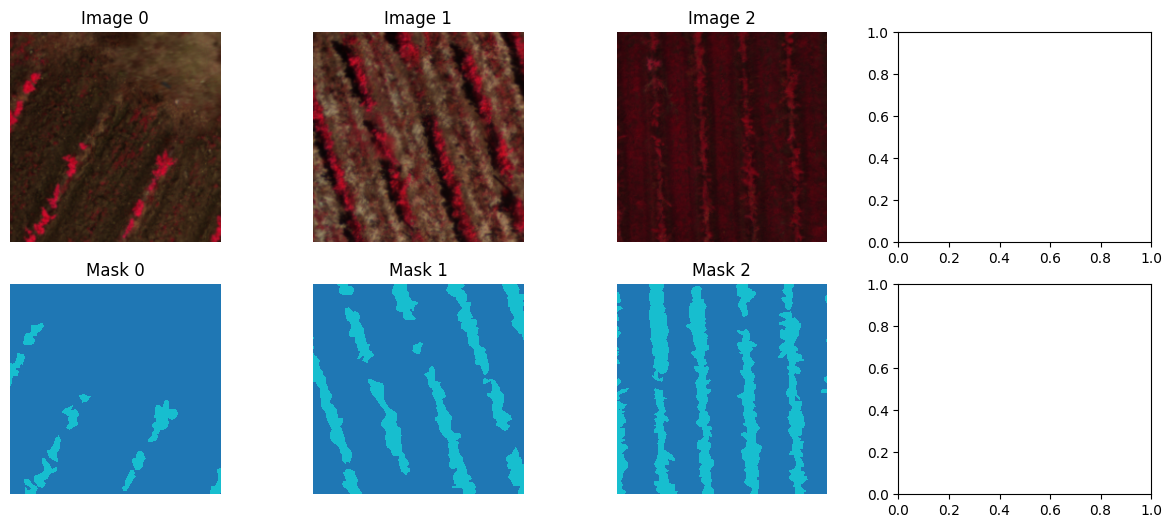

In [94]:
# Visualize a batch of training data
batch = next(iter(train_loader))
visualize_batch(
    batch, 
    num_samples=3, 
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

In [95]:
state = "../checkpoints_512_r50_view4/last.ckpt"
state_dict= torch.load(state)["state_dict"]
state_dict = clean_state_dict(state_dict, prefix_to_strip = "backbone.", skip_if_contains=["prediction_head", "projection_head"])
resnet = torchvision.models.resnet50(weights=None)
backbone_dim = 2048
resnet = modify_resnet_for_4_channels(resnet, 4)

# Remove final FC layer and store the feature extractor
modules = list(resnet.children())[:-1]
modules.append(Flatten())
resnet = nn.Sequential(*modules)
resnet.load_state_dict(state_dict)

# Now create the UNet segmentation model
model = ResNetSegmentationModel(
    sequential_backbone=resnet,  # Pass the loaded resnet
    num_classes=CONFIG["num_classes"],
    img_size=CONFIG["img_size"],
    lr=CONFIG["lr"],
    weight_decay=CONFIG["weight_decay"]
)


Detected feature dimensions: layer1=64, layer2=64, layer3=64, layer4=256


In [96]:
# Create callbacks
from pytorch_lightning.callbacks import RichProgressBar

checkpoint_callback = ModelCheckpoint(
    dirpath="segmentation_checkpoints",
    filename="r50-all-{epoch:02d}-{val_loss:.4f}",
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    save_last=True
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")
unfreeze_callback = UnfreezeBackboneCallback(unfreeze_after=CONFIG["unfreeze_backbone_after"])

# Create logger (you can use either WandbLogger or TensorBoardLogger)
# Comment out if you don't want to use wandb

wandb_logger = WandbLogger(project="ViT-Segmentation", log_model=False)

# Create trainer
trainer = pl.Trainer(
    max_epochs=CONFIG["epochs"],
    accelerator="cuda",  # Uses GPU if available
    devices=1,
    callbacks=[checkpoint_callback, lr_monitor, unfreeze_callback, RichProgressBar()],
    logger=wandb_logger,  # Comment out if not using wandb
)
   
# Use before training
print_model_info(model)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model Architecture: ResNetSegmentationModel
Total Parameters: 26,798,082
Trainable Parameters: 3,286,914
--------------------------------------------------
Feature map sizes:
  layer0: (1, 64, 112, 112)
  layer1: (1, 64, 112, 112)
  layer2: (1, 64, 112, 112)
  layer3: (1, 64, 56, 56)
  layer4: (1, 256, 56, 56)


In [97]:
# Train the model
trainer.fit(model, train_loader, val_loader)
import wandb
wandb.finish()

Epoch 99/99 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s v_num: cz5f train_loss: 0.119       
                                                                               val_loss: 0.325 val_accuracy: 0.887 

`Trainer.fit` stopped: `max_epochs=100` reached.


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
lr-AdamW,██████████████████▄▄▄▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
val_accuracy,▁▁▁▁▁▆███▇▇▇████████████████████████████
val_loss,██████▇▆▆▅▄▄▃▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
lr-AdamW,0.0
train_loss,0.11939
trainer/global_step,99
val_accuracy,0.88745


Detected feature dimensions: layer1=64, layer2=64, layer3=64, layer4=256


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.3120
Accuracy: 0.8901
Total F1 Score (micro-avg): 0.8901
Mean IoU: 0.7309

Per-class metrics:
Background:
  Precision: 0.9220
  Recall: 0.9340
  F1 Score: 0.9265
  IoU: 0.8637
Vines:
  Precision: 0.7536
  Recall: 0.7136
  F1 Score: 0.7201
  IoU: 0.5982

Confusion Matrix:
tensor([[3360542,  224565],
        [ 289274,  992691]], device='cuda:0')


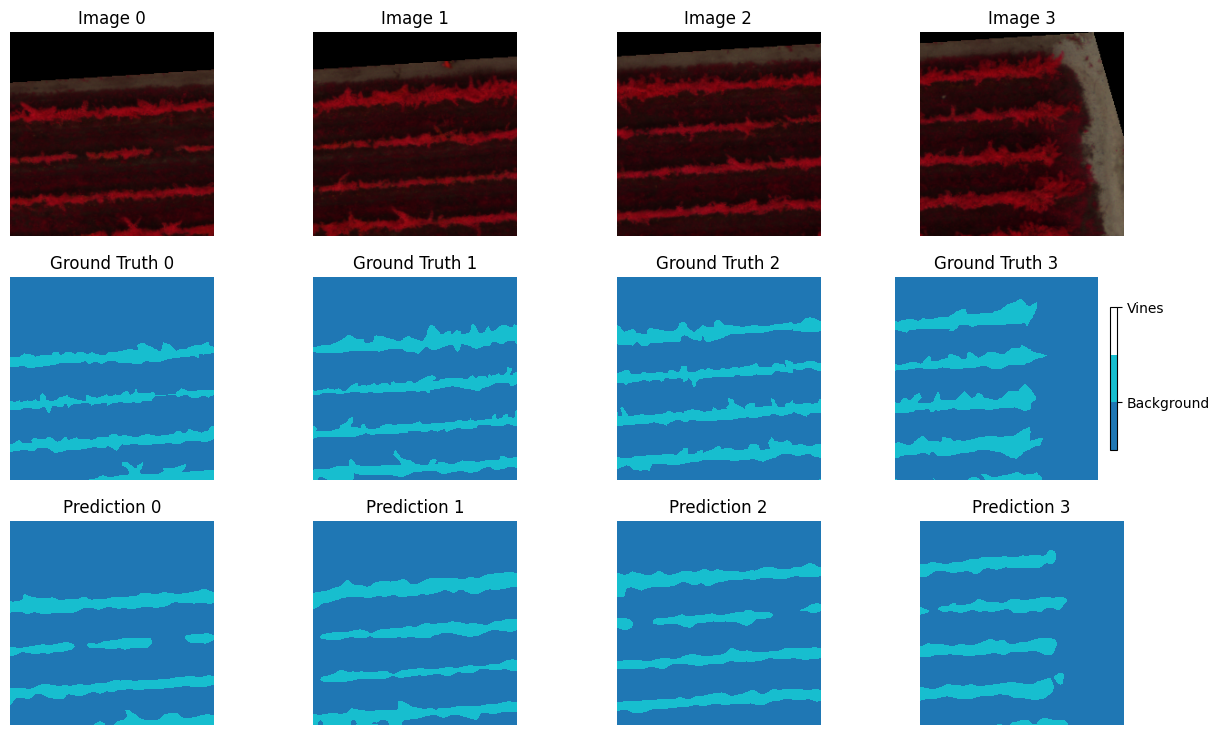

Loaded best model from C:\Users\judoj\Documents\programming\multi_ssl\notebooks\segmentation_checkpoints\r50-all-epoch=41-val_loss=0.2971.ckpt


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.1990
Accuracy: 0.9365
Total F1 Score (micro-avg): 0.9365
Mean IoU: 0.7424

Per-class metrics:
Background:
  Precision: 0.9869
  Recall: 0.9436
  F1 Score: 0.9642
  IoU: 0.9318
Vines:
  Precision: 0.6219
  Recall: 0.8600
  F1 Score: 0.6993
  IoU: 0.5529

Confusion Matrix:
tensor([[6826498,  412231],
        [  92628,  546275]], device='cuda:0')


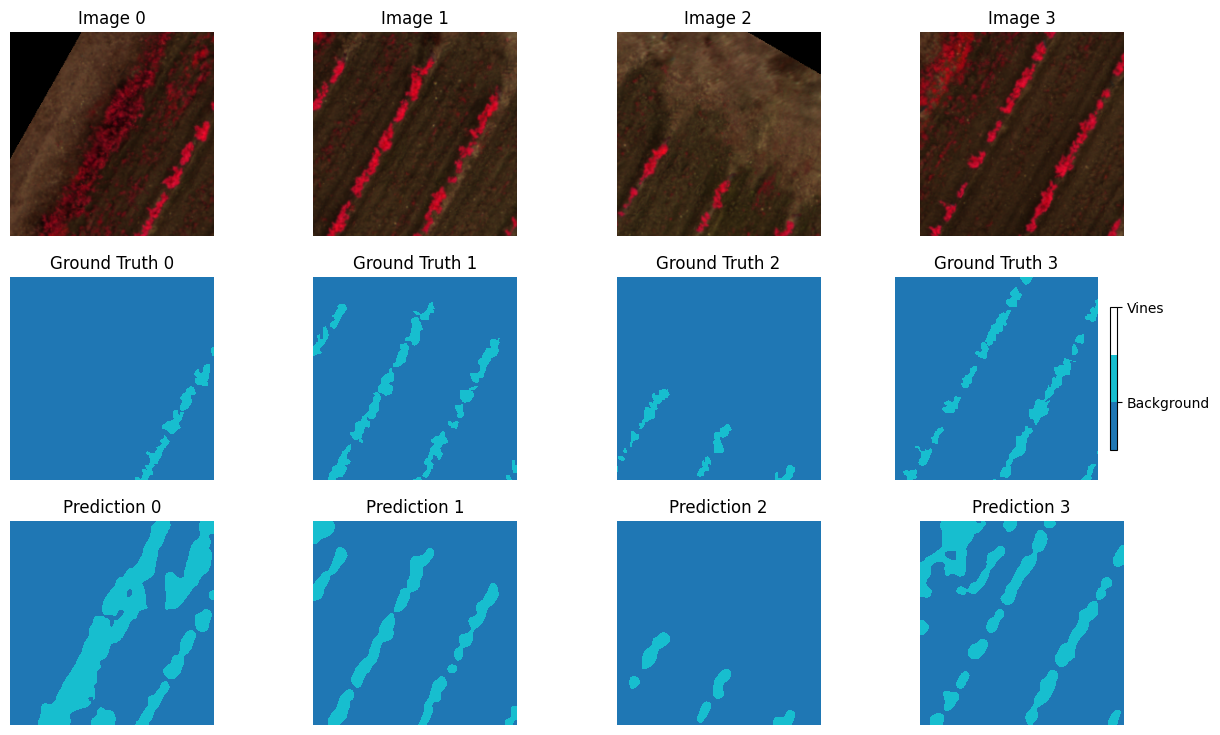

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\core\module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`



===== Test Set Evaluation =====
Loss: 0.3260
Accuracy: 0.8868
Total F1 Score (micro-avg): 0.8868
Mean IoU: 0.7204

Per-class metrics:
Background:
  Precision: 0.9426
  Recall: 0.9163
  F1 Score: 0.9277
  IoU: 0.8659
Vines:
  Precision: 0.7064
  Recall: 0.7853
  F1 Score: 0.7266
  IoU: 0.5749

Confusion Matrix:
tensor([[5198083,  471496],
        [ 324736, 1080501]], device='cuda:0')


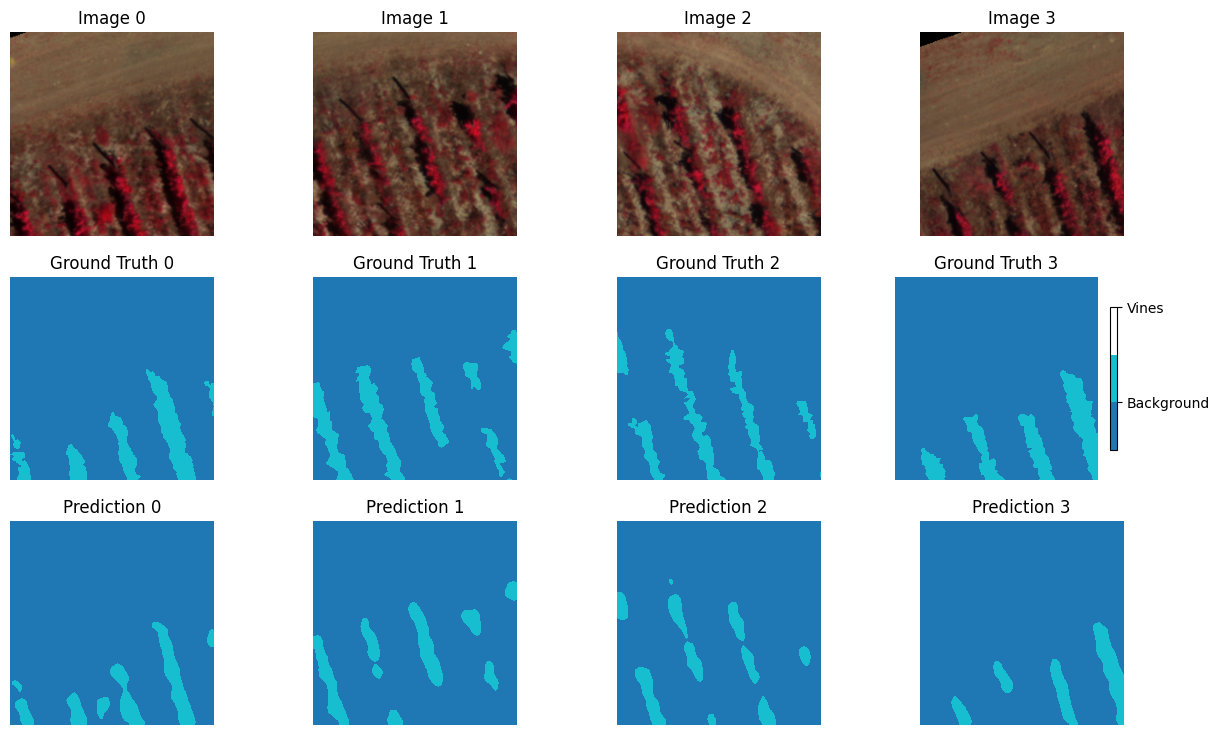

In [100]:
# Load the best model
device = "cuda"

best_model_path = checkpoint_callback.best_model_path
best_model = ResNetSegmentationModel.load_from_checkpoint(best_model_path, 
                                                          sequential_backbone =resnet.to("cpu"))
best_model.to(device)
best_model.eval()
uber_test_results_e2 = best_model.test(val_loader)

visualize_predictions(
    model=best_model,
    dataloader=val_loader,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

print(f"Loaded best model from {best_model_path}")
uber_test_results_v = best_model.test(test_loader_v)


visualize_predictions(
    model=best_model,
    dataloader=test_loader_v,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

uber_test_results_q = best_model.test(test_loader_q)

visualize_predictions(
    model=best_model,
    dataloader=test_loader_q,
    device=device,
    num_samples=4,
    class_names=CONFIG["class_names"],
    num_classes=CONFIG["num_classes"]
)

In [73]:
# Save just the state dict for easier loading in production
model_state_dict_path = "segmentation_checkpoints/r50seg_all_best_state_dict.pth"
torch.save(best_model.state_dict(), model_state_dict_path)
print(f"Saved model state dict to {model_state_dict_path}")

Saved model state dict to segmentation_checkpoints/r50seg_all_best_state_dict.pth
